In [1]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import pystan, GPy, scipy, stan_utility
import pandas as pd

# Example: one-way hierarchical model 

## centered model 

In [4]:
code = """
data {
    int<lower=0> N;
    int<lower=1> G;
    real y[N];
    int<lower=1, upper=G> group[N];
    real<lower=0> sigma;
}
parameters {
    real mu;
    real<lower=0> tau;
    real theta[G];
}
transformed parameters{
    real yhat[N];
    
    for(i in 1:N)
        yhat[i] = theta[group[i]];
}
model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 2.5);
    theta ~ normal(mu, tau);
    y ~ normal(yhat, sigma);        
}
"""

# model = pystan.StanModel(model_code=code)

model = pystan.StanModel(file='stan-models/hierarchical-centered.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1b3c4120f866dbd0960a54c06cecc68f NOW.


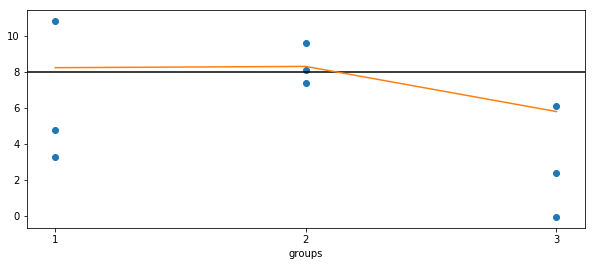

In [88]:
mu = 8.
tau = 3.
ysigma=3
n = 10
g = 3
nrep = 3

# theta = scipy.stats.norm.rvs(mu, scale=tau, size=n)
# y = scipy.stats.norm.rvs(theta, scale=ysigma)

theta = scipy.stats.norm.rvs(mu, scale=tau, size=g)
y = scipy.stats.norm.rvs(np.repeat(theta, nrep), scale=ysigma)

plt.figure(figsize=(10,4))

plt.axhline(mu, c='k')

#plt.plot(theta)
# plt.plot(np.repeat(theta, nrep))
# plt.plot(y)

#plt.boxplot([y[i*nrep:(i+1)*nrep] for i in range(g)])
plt.plot(range(1, g+1), theta, 'C1')
plt.scatter(np.repeat(np.arange(1, g+1), nrep), y)
plt.xticks(np.arange(1, g+1))
plt.xlabel('groups')

plt.savefig('figures/hierarchical-data.pdf', bbox_inches='tight')

In [83]:
# config = {
#     'J': n,
#     'y': y,
#     'sigma': ysigma
# }

config = {
    'N': g*nrep,
    'G': g,
    'group': np.repeat(1+np.arange(g), nrep),
    'y': y,
    'sigma': ysigma
}

samples = model.sampling(data=config, chains=4, iter=2000)
samples

Inference for Stan model: anon_model_1b3c4120f866dbd0960a54c06cecc68f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         8.44    0.06   1.63   4.58   7.63   8.58   9.51  11.08  833.0    1.0
tau        1.68    0.07   1.73   0.26   0.66   1.18   2.07   6.21  575.0   1.01
theta[0]   9.05    0.04   1.27   6.63   8.14   9.05    9.9  11.54  847.0    1.0
theta[1]   9.02    0.04   1.32   6.58   8.13   9.04   9.89  11.68  928.0    1.0
theta[2]   8.68    0.04   1.31   6.09   7.81   8.67   9.56  11.26 1044.0    1.0
yhat[0]    9.05    0.04   1.27   6.63   8.14   9.05    9.9  11.54  847.0    1.0
yhat[1]    9.05    0.04   1.27   6.63   8.14   9.05    9.9  11.54  847.0    1.0
yhat[2]    9.05    0.04   1.27   6.63   8.14   9.05    9.9  11.54  847.0    1.0
yhat[3]    9.02    0.04   1.32   6.58   8.13   9.04   9.89  11.68  928.0    1.0
yhat[4]    

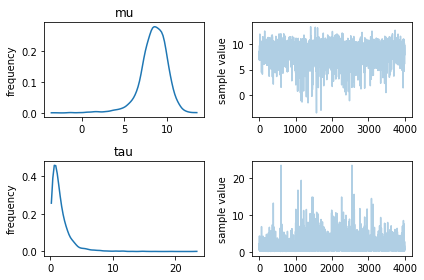

In [84]:
samples.plot(['mu', 'tau']);
plt.tight_layout()

In [85]:
stan_utility.check_treedepth(samples)

0 of 4000 iterations saturated the maximum tree depth of 10 (0%)


In [86]:
stan_utility.check_div(samples)

215.0 of 4000 iterations ended with a divergence (5.375%)
Try running with larger adapt_delta to remove the divergences


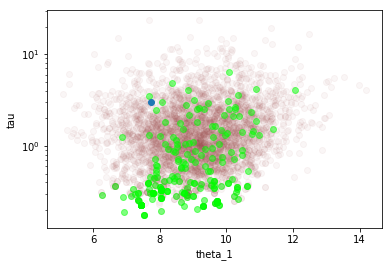

In [87]:
nondiv_params, div_params = stan_utility.partition_div(samples)

light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

plt.scatter([x[0] for x in nondiv_params['theta']], nondiv_params['tau'], \
             color = mid_highlight, alpha=0.05)
plt.scatter([x[0] for x in div_params['theta']], div_params['tau'], \
             color = green, alpha=0.5)

plt.semilogy()
plt.scatter(theta[0], tau)

plt.xlabel('theta_1')
plt.ylabel('tau')

In [238]:
samp = samples.extract()
samp

OrderedDict([(u'mu',
              array([ 6.42795734,  3.44685943,  6.41218909, ...,  5.27414174,
                      5.70672168,  5.77495939])),
             (u'tau',
              array([ 2.18294646,  1.54437189,  1.87700009, ...,  2.68359684,
                      2.80186867,  2.74533077])),
             (u'theta',
              array([[ 8.61927488,  5.2194834 ,  5.74261099, ...,  7.56547561,
                       6.63129543,  1.6281565 ],
                     [ 7.56314754,  1.7429455 ,  2.94655848, ...,  5.54023328,
                       5.96540487,  3.22052467],
                     [ 8.28611477,  7.67794047,  3.31516833, ...,  9.83003984,
                       6.51666499,  5.32665828],
                     ..., 
                     [ 6.78369439,  5.31756261,  6.45144817, ...,  7.05294434,
                       3.52547998,  0.57703281],
                     [ 9.30095371,  5.15067529,  7.19401749, ...,  3.15475581,
                       3.77796842,  7.82040363],
          

In [239]:
samp['mu'].shape

(4000,)

In [240]:
samp['tau'].shape

(4000,)

In [241]:
samp['theta'].shape

(4000, 30)

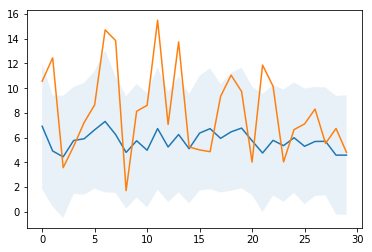

In [242]:
plt.plot(samp['theta'].mean(0))
plt.fill_between(range(g), 
                 samp['theta'].mean(0) - 1.98*samp['theta'].std(0), 
                 samp['theta'].mean(0) + 1.98*samp['theta'].std(0),
                alpha=.1)

plt.plot(theta)

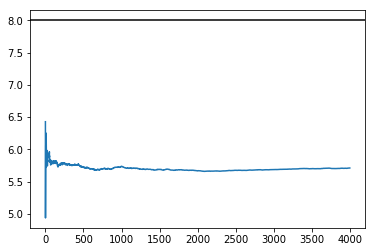

In [243]:
plt.plot(np.cumsum(samp['mu'])/(1.+np.arange(4000)))
plt.axhline(mu, color='k')

## non-centered model 

In [89]:
code = """
data {
    int<lower=0> N;
    int<lower=1> G;
    real y[N];
    int<lower=1, upper=G> group[N];
    real<lower=0> sigma;
}
parameters {
    real mu;
    real<lower=0> tau;
    real theta_tilde[G];
}
transformed parameters{
    real yhat[N];
    real theta[G];
    
    for (j in 1:G)
        theta[j] = mu + tau * theta_tilde[j];
    
    for(i in 1:N)
        yhat[i] = theta[group[i]];
}
model {
    mu ~ normal(0, 5);
    tau ~ cauchy(0, 2.5);
    theta_tilde ~ normal(0, 1);
    y ~ normal(yhat, sigma);        
}
"""

model_nc = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d7c07a87ea244c8ae619107d225a4c6 NOW.


In [247]:
# config = {
#     'J': n,
#     'y': y,
#     'sigma': ysigma
# }

config = {
    'N': g*nrep,
    'G': g,
    'group': np.repeat(1+np.arange(g), nrep),
    'y': y,
    'sigma': ysigma
}

samples = model_nc.sampling(data=config, chains=4, iter=2000)
samp = samples.extract()

In [248]:
samples

Inference for Stan model: anon_model_1d7c07a87ea244c8ae619107d225a4c6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                5.85    0.02   1.11   3.63   5.09   5.88   6.61   8.02 4000.0    1.0
tau               1.86    0.03   1.33   0.09   0.78   1.63    2.7   4.94 1907.0    1.0
theta_tilde[0]    0.43    0.02   0.98  -1.49  -0.25   0.43   1.11   2.29 4000.0    1.0
theta_tilde[1]   -0.29    0.02   0.97  -2.17  -0.94   -0.3   0.36   1.66 4000.0    1.0
theta_tilde[2]   -0.46    0.01   0.94  -2.27  -1.09  -0.49   0.19   1.46 4000.0    1.0
theta_tilde[3]  9.7e-4    0.01   0.92  -1.78  -0.62-1.4e-3   0.63   1.75 4000.0    1.0
theta_tilde[4]    0.03    0.02   0.98  -1.91  -0.63   0.03   0.68   1.97 4000.0    1.0
theta_tilde[5]    0.35    0.02   0.95  -1.54   -0.3   0.36   1.01   2.15 4000.0    1.0
theta_tilde[6]    0.59    0.

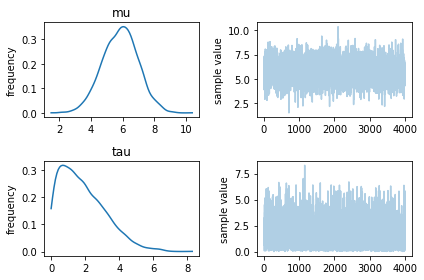

In [249]:
samples.plot(['mu', 'tau']);
plt.tight_layout()

In [250]:
stan_utility.check_treedepth(samples)

0 of 4000 iterations saturated the maximum tree depth of 10 (0%)


In [251]:
stan_utility.check_div(samples)

0.0 of 4000 iterations ended with a divergence (0.0%)


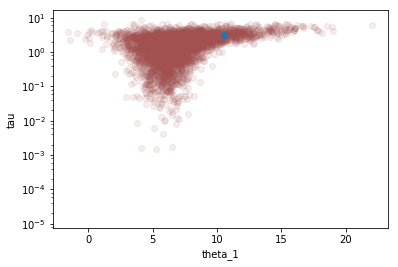

In [258]:
nondiv_params, div_params = stan_utility.partition_div(samples)

light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

plt.scatter([x[0] for x in div_params['theta']], div_params['tau'], \
             color = green, alpha=0.5)

plt.scatter([x[0] for x in nondiv_params['theta']], nondiv_params['tau'], \
             color = mid_highlight, alpha=0.1)


plt.semilogy()

plt.scatter(theta[0], tau)

plt.xlabel('theta_1')
plt.ylabel('tau')


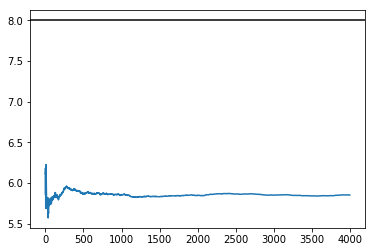

In [253]:
plt.plot(np.cumsum(samp['mu'])/(1.+np.arange(4000)))
plt.axhline(mu, color='k')

# GP model 

In [ ]:
def plotFunctionSamples(param, plotKwargs={}, fillKwargs={}, **kwargs):
    plotKwargs.update(kwargs)
    fillKwargs.update(kwargs)
    
    plt.plot(x, param.mean(0), **plotKwargs)
    plt.fill_between(x, param.mean(0)-1.98*param.std(0), param.mean(0)+1.98*param.std(0), alpha=.1, **fillKwargs)

In [ ]:
code = """
data {
  int<lower=1> N;
  vector[N] y;
  real x[N];
}
parameters {
  //constrain hyperparameters to be positive
  real<lower=0> length_scale;
  real<lower=0> alpha;
  real<lower=0> sigma;
  vector[N] f_eta;
}
transformed parameters {
  vector[N] f;
  {
    // define unneeded variables inside brackets 
    // to prevent storage by sampler
    matrix[N, N] L_cov;
    matrix[N, N] cov;
    cov = cov_exp_quad(x, alpha, length_scale);
    for (n in 1:N)
      cov[n, n] = cov[n, n] + 1e-12;
    L_cov = cholesky_decompose(cov);
    f = L_cov * f_eta;
  }
}
model {
  length_scale ~ gamma(2, 2);
  alpha ~ normal(0, 1);
  sigma ~ normal(0, 1);
  f_eta ~ normal(0, 1);
  y ~ normal(f, sigma);
}
"""

model = pystan.StanModel(model_code=code)

In [ ]:
n = 20
x = np.linspace(-1,1,n)
k = GPy.kern.RBF(1)

cov = np.tile(k.K(x[:,None]), (2,2))
cov[:n, :n] += .1 * np.eye(n)

s = scipy.stats.multivariate_normal.rvs(np.zeros(2*n), cov)
y, f = s[:n], s[n:]

plt.plot(x, f)
plt.scatter(x, y)

In [ ]:
cfg = {
    'N': n,
    'y': y,
    'x': x
}

samples = model.sampling(data=cfg, iter=2000)
samples

In [ ]:
samp = samples.extract()

In [ ]:
samp.keys()

In [ ]:
plt.plot(x, samp['f'].mean(0))
plt.fill_between(x, samp['f'].mean(0)-1.98*samp['f'].std(0), samp['f'].mean(0)+1.98*samp['f'].std(0), alpha=.1)

plt.plot(x, f, c='C1')

# Add derivative sampling 

## Allow derivate prior

In [ ]:
code = """
data {
  int<lower=1> N;
  vector[N] y;
  real x[N];
}
parameters {
  //constrain hyperparameters to be positive
  real<lower=0> length_scale;
  real<lower=0> alpha;
  real<lower=0> sigma;
  vector[2*N] eta;
}
transformed parameters {
  vector[N] f;
  vector[N] df;
  
  {
    matrix[2*N,2*N] L_cov;
    matrix[N, N] cov;
    vector[N] K_div_f;
      matrix[N, N] dK;
      matrix[N, N] ddK;
      matrix[N, N] v_pred;
      vector[N] df_pred_mu;
      matrix[N, N] cov_df_pred;
      matrix[N, N] nug_pred;
      real diff;
      real lsInv = 1./length_scale/length_scale;

      nug_pred = diag_matrix(rep_vector(1e-12,N));
    cov = cov_exp_quad(x, alpha, length_scale);
    for (n in 1:N)
      cov[n, n] = cov[n, n] + 1e-12;
    L_cov = cholesky_decompose(cov);
    f = L_cov[1:N,1:N] * f_eta[1:N];
    
    //derivative
    K_div_f = mdivide_left_tri_low(L_cov, f);
      K_div_f = mdivide_right_tri_low(K_div_f',L_cov)';

      // compute dK: cov(df, f), and ddK: cov(df, df)
      dK = cov_exp_quad(x, alpha, length_scale);
      ddK = cov_exp_quad(x, alpha, length_scale);
      for (i in 1:N){
        for (j in 1:N){
          diff = x[i] - x[j];

          dK[i,j] = dK[i,j] * (-lsInv * diff);
          ddK[i,j] = ddK[i,j] * (1.-lsInv*diff*diff) * lsInv;
        }
      }
      
      df_pred_mu = (dK * K_div_f);

      v_pred = mdivide_left_tri_low(L_cov, dK');
      cov_df_pred = ddK - v_pred' * v_pred;
      L_df = cholesky_decompose(cov_df_pred);
      
      df = L_df * df_eta;
  }
}
model {
  length_scale ~ gamma(2, 2);
  alpha ~ normal(0, 1);
  sigma ~ normal(0, 1);
  f_eta ~ normal(0, 1);
  df_eta ~ normal(0, 1);
  y ~ normal(f, sigma);
}
"""

model_derivative_prior = pystan.StanModel(model_code=code)

In [ ]:
cfg = {
    'N': n,
    'y': y,
    'x': x
}

samples = model_derivative_prior.sampling(data=cfg, iter=2000)
samples

In [ ]:
samp = samples.extract()

In [ ]:
samp.keys()

In [ ]:
plotFunctionSamples(samp['f'])
plt.plot(x, f, c='C1')

plt.twinx()
plotFunctionSamples(samp['df'], color='C1')

# Delorean Model 

In [52]:
delorean = pystan.StanModel(file='stan-models/delorean/exact.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2d076b8f826bca8c4fe13aba5c721868 NOW.


In [75]:
ds = 'windram'

meta = pd.read_csv('data/delorean/%s.cell.meta.csv'%ds, index_col=0)
expr = pd.read_csv('data/delorean/%s.expr.csv'%ds, index_col=0)
genemeta = pd.read_csv('data/delorean/%s.gene.meta.csv'%ds, index_col=0)

In [76]:
meta.shape, expr.shape, genemeta.shape

((48, 4), (150, 48), (150, 2))

In [115]:
meta.head()

,cell,obstime,condition,capture
1,GSM734540,2,Botrytis,2
2,GSM734541,4,Botrytis,4
3,GSM734542,6,Botrytis,6
4,GSM734543,8,Botrytis,8
5,GSM734544,10,Botrytis,10


(array([ 6.,  4.,  4.,  6.,  4.,  4.,  6.,  4.,  4.,  6.]),
 array([  2. ,   6.6,  11.2,  15.8,  20.4,  25. ,  29.6,  34.2,  38.8,
         43.4,  48. ]),
 <a list of 10 Patch objects>)

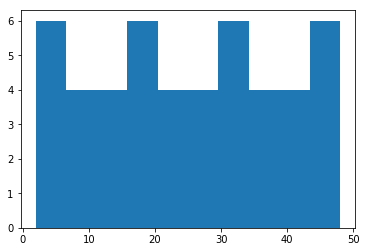

In [78]:
plt.hist(meta.obstime)

In [79]:
expr.head()

,GSM734540,GSM734541,GSM734542,GSM734543,GSM734544,GSM734545,GSM734546,GSM734547,GSM734548,GSM734549,...,GSM734578,GSM734579,GSM734580,GSM734581,GSM734582,GSM734583,GSM734584,GSM734585,GSM734586,GSM734587
CATMA1a00350,9.710897,9.832590,9.884595,9.945775,9.877853,10.202463,9.840159,10.088847,9.810455,9.180298,...,10.117931,10.066953,10.021325,10.377542,9.791147,10.411251,10.198705,10.018750,10.034907,9.884397
CATMA1a00725,12.088297,12.452569,12.808097,12.905720,12.749294,12.902973,12.976291,12.694036,13.259558,12.801453,...,12.436501,12.670511,12.383517,12.084563,12.544240,12.711120,12.803843,12.613040,12.277474,12.115316
CATMA1a00790,6.852164,6.556423,5.563841,5.361028,5.634317,7.145824,5.293819,6.482773,6.372674,5.784951,...,5.716546,6.410615,6.574702,6.308654,6.397054,6.673808,4.963005,5.639637,5.738830,5.041594
CATMA1a02710,9.362607,9.646485,8.855508,8.812352,8.742348,9.077515,9.166195,9.859782,9.956077,9.171175,...,9.053681,8.886858,9.312501,9.417784,10.187124,9.768930,9.970470,9.063829,9.036554,9.740412
CATMA1a05095,7.895253,8.104990,7.441710,7.813741,7.869875,7.599806,7.838487,7.913710,7.438730,7.879663,...,7.999981,7.979035,8.282805,8.069738,8.147884,7.997745,8.299933,8.232949,8.108524,8.110180


In [80]:
genemeta.head()

,gene,TAIR9
1,CATMA1a00350,AT1G01360
2,CATMA1a00725,AT1G01720
3,CATMA1a00790,AT1G01780
4,CATMA1a02710,AT1G03850
5,CATMA1a05095,AT1G06080


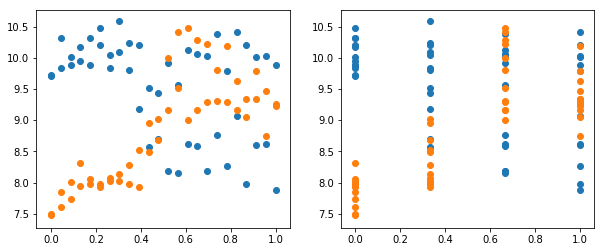

In [125]:
tind = range(0,expr.shape[1],1)

gind = range(2)
gind = [0, 6]

time = meta.obstime.values[tind]
exp = expr.values[gind,:][:, tind]

time = 1.*(time-time.min())/(time.max()-time.min())

timeTrain = np.tile(np.repeat(range(4), 6), 2)
timeTrain = 1.*(timeTrain-timeTrain.min())/(timeTrain.max()-timeTrain.min())

plt.figure(figsize=(10, 4))
plt.subplot(121)
for i in range(exp.shape[0]):
    plt.scatter(time, exp[i,:])
    
plt.subplot(122)
for i in range(exp.shape[0]):
    plt.scatter(timeTrain, exp[i,:])

In [155]:
config = dict(
    C = time.shape[0], #meta.shape[0], # number of cells
    G = 2, # number of genes
    H = 0, # number of held-out genes
    
    periodic = 0, # non-periodic fxn
    period = 0,
    
#     time = meta.obstime.values[:10], # observation time
#     expr = expr.values[:2,:10], # expression data
#     phi = expr.mean(1).values[:2,], # gene mean
    
    time = timeTrain,
    expr= exp,
    phi = exp.mean(1),
    
    # hyperparameters
    mu_psi = 1.,
    sigma_psi = 1.,
    mu_omega = 1.,
    sigma_omega = 1.,
    sigma_tau=0.5,
    l=1.5,
    
    heldout_psi=[],
    heldout_omega=[],
    
    numtest=30,
    testinput = np.linspace(-.5, 1.5, 30),
)

In [156]:
samples = delorean.sampling(data=config)
samp = samples.extract()
samples

Inference for Stan model: anon_model_2d076b8f826bca8c4fe13aba5c721868.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau[0]                -0.3  6.6e-3   0.31  -0.95   -0.5  -0.28  -0.07   0.24 2263.0    1.0
tau[1]               -0.27  5.1e-3   0.32  -0.96  -0.47  -0.25  -0.04    0.3 4000.0    1.0
tau[2]               -0.16  5.4e-3   0.34  -0.88  -0.38  -0.13   0.08   0.45 4000.0    1.0
tau[3]               -0.03  8.4e-3   0.38  -0.89  -0.26   0.03   0.23   0.58 2003.0    1.0
tau[4]               -0.16  5.2e-3   0.33  -0.86  -0.38  -0.13   0.07    0.4 4000.0    1.0
tau[5]               -0.17  6.7e-3   0.33  -0.88  -0.39  -0.14   0.06   0.39 2386.0    1.0
tau[6]              9.4e-4  5.0e-3   0.32  -0.68   -0.2   0.04   0.22   0.55 4000.0    1.0
tau[7]                0.02  5.8e-3   0.31  -0.68  -0.16   0.06   0.24   0.55 2854.0

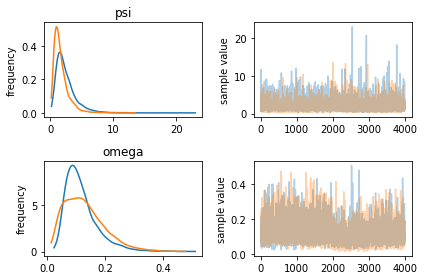

In [150]:
samples.plot(['psi', 'omega']);
plt.tight_layout()

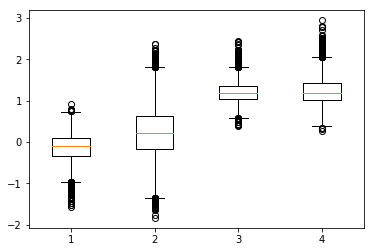

In [151]:
plt.boxplot([[samp['tau'][:, j] for j in range(i*6, (i+1)*6)] for i in range(4)]);

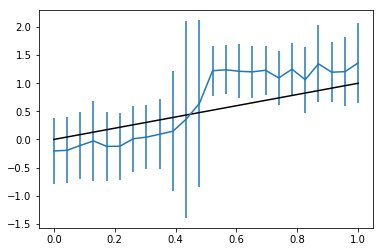

In [152]:
plt.errorbar(time[:24], samp['tau'].mean(0)[:24], yerr = 1.98*samp['tau'].std(0)[:24])
plt.plot([time.min(), time.max()], [time.min(), time.max()], c='k')

In [153]:
samp.keys()

[u'tau',
 u'psi',
 u'omega',
 u'predictedmean',
 u'predictedvar',
 u'logmarglike',
 u'lp__']

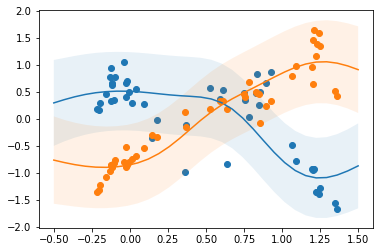

In [154]:
for i in range(exp.shape[0]):
    mu = samp['predictedmean'][:,i,:].mean(0)
    var = samp['predictedvar'][:,i,:].mean(0)
    std = np.sqrt(var)
    
    plt.plot(config['testinput'], mu)
    plt.fill_between(config['testinput'], mu-1.98*std, mu+1.98*std,alpha=.1)

    plt.scatter(samp['tau'].mean(0), exp[i,:]-exp[i,:].mean(), color='C%d'%i)